<a href="https://colab.research.google.com/github/miichenry/machinelearning_UNIL/blob/main/Labs/S6_1_Composing_Music_With_RNNs_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: Comparing Different Types of Recurrent and Convolutional Neural Networks to Compose Bach Chorales

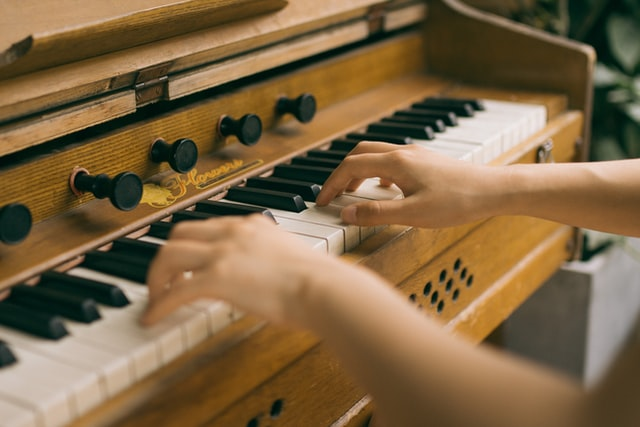

Can you compose a new [Bach chorale](https://en.wikipedia.org/wiki/List_of_chorale_harmonisations_by_Johann_Sebastian_Bach) using recurrent and/or convolutional neural networks? 🎼 🎶 🎹

**Source**: Photo by <a href="https://unsplash.com/@onice?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Joey Huang</a> on <a href="https://unsplash.com/s/photos/organ-music?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

This exercise adapts Géron et al.'s Jupyter notebook exercises for [chapter 15](https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb) \([License](https://github.com/ageron/handson-ml2/blob/master/LICENSE)) of his book ["Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition"](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).
  

## Part I: Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Loading Tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Let's import two more libraries:

In [6]:
import pooch # Import the pooch library to load data from URL
import pandas as pd # Import the pandas library to handle arrays

Second, let's load the data:

In [7]:
url = "https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EdQBrnnm_kJLhEYL4ZEaTxAB0XlVYiQrXtDRUKMxHZVIlg?download=1"

In [8]:
files = pooch.retrieve(url,processor=pooch.Unzip(),known_hash='57b0aa3c1716e862b9ab9a941d516b88841c350a08ee216027ecb69f59f442a0')

In [9]:
# Finds the directory containing the files and ...
jsb_chorales_dir = Path(files[0]).parent.parent

# ... Sort these files into training/validation/test
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [10]:
# Load the chorales from the training, validation, and test set
def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

Third, let's define the functions Géron implemented to listen to these chorales. According to Géron:

"*You don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer.*"

<a name="play_chords"></a>

In [11]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    '''
    Reads chords (sets of 4 notes) in a chorale (list of chords)
    and outputs an audio file that can be played.

    Arguments:
        chords: A list of chords, for instance a full chorale
    Optional arguments:
        tempo: The tempo of the music
        amplitude: The amplitude of the sine waves to be played
        sample_rate: How many frequencies are sampled ~ music quality
    '''
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

## Part II: Preliminary Data Analysis and Preprocessing

The dataset is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played).

Our goal is to train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Once trained, we can use this model to generate Bach-like music, one note at a time. We can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on.

**Q1) Check that notes range from `min_note = 36` (which is C1, i.e. C/Do on octave 1) to `max_note = 81` (which is A5, i.e. A/La on octave 5), including `0` for silences. Calculate the total number of notes `n_notes`.**

First, explore the dataset:

In [12]:
# Explore the dataset: How is it structured? What does a sample look like? etc.

In [13]:
train_chorales

[[[74, 70, 65, 58],
  [74, 70, 65, 58],
  [74, 70, 65, 58],
  [74, 70, 65, 58],
  [75, 70, 58, 55],
  [75, 70, 58, 55],
  [75, 70, 60, 55],
  [75, 70, 60, 55],
  [77, 69, 62, 50],
  [77, 69, 62, 50],
  [77, 69, 62, 50],
  [77, 69, 62, 50],
  [77, 70, 62, 55],
  [77, 70, 62, 55],
  [77, 69, 62, 55],
  [77, 69, 62, 55],
  [75, 67, 63, 48],
  [75, 67, 63, 48],
  [75, 69, 63, 48],
  [75, 69, 63, 48],
  [74, 70, 65, 46],
  [74, 70, 65, 46],
  [74, 70, 65, 46],
  [74, 70, 65, 46],
  [72, 69, 65, 53],
  [72, 69, 65, 53],
  [72, 69, 65, 53],
  [72, 69, 65, 53],
  [72, 69, 65, 53],
  [72, 69, 65, 53],
  [72, 69, 65, 53],
  [72, 69, 65, 53],
  [74, 70, 65, 46],
  [74, 70, 65, 46],
  [74, 70, 65, 46],
  [74, 70, 65, 46],
  [75, 69, 63, 48],
  [75, 69, 63, 48],
  [75, 67, 63, 48],
  [75, 67, 63, 48],
  [77, 65, 62, 50],
  [77, 65, 62, 50],
  [77, 65, 60, 50],
  [77, 65, 60, 50],
  [74, 67, 58, 55],
  [74, 67, 58, 55],
  [74, 67, 58, 53],
  [74, 67, 58, 53],
  [72, 67, 58, 51],
  [72, 67, 58, 51],


In [14]:
type(train_chorales)

list

In [15]:
len(train_chorales)

229

Second, let's group all of the chorales' notes in a set called `notes`:

In [16]:
notes = set() # Initialize the notes with an empty set
for chorales in (train_chorales, valid_chorales, test_chorales): # Loop through chorales in training/validation/test sets
    for chorale in chorales: # Loop through all chorales
        for chord in chorale: # Loop through chords within a chorale
            notes |= set(chord) # Add notes that are in chord but not yet in notes

Third, calculate `min_note` and `max_note`.

Hint: Be careful to exclude 0 when calculating `min_note`.

In [17]:
type(notes)

set

In [18]:
min_note = min(notes - {0})
max_note = max(notes)

In [19]:
# This will return an error message if your code is erroneous
assert min_note == 36
assert max_note == 81

Finally, calculate the total number of notes `n_notes`.

In [20]:
n_notes = len(notes)

In [21]:
# This will return an error message if your code is erroneous
assert n_notes == 47

**Q2) What is the training/validation/test split?**

Hint: You may use the [`len`](https://docs.python.org/3/library/functions.html#len) build-in function to get the length of a list

In [22]:
# Calculate the number of chorales in each of the training/validation/test sets

In [23]:
set = ["training", "validation", "test"]
count = (0)
n_chorale = []
for chorales in (train_chorales, valid_chorales, test_chorales):
  n_chorale.append(len(chorales))
  print(each[count], len(chorales))
  count += 1

NameError: ignored

In [ ]:
# What is the training/validation/test split (in %)?
set = ["training", "validation", "test"]
count = (0)
split = []
for n in n_chorale:
  split.append(n/382*100)
  print(set[count], n/382*100)
  count += 1

**Q3) Listen to a few chorales 🎵**

Hint 1: Use the `play_chords` function defined above. Type `play_chords?` to display its documentation.

Hint 2: You can start by selecting chorales from the training set `train_chorales`.

In [ ]:
# Explore `train_chorales` and `play_chords?` to get some intuition
play_chords?

In [ ]:
# Use `play_chords` to produce chorales you can listen to
play_chords(train_chorales[0], tempo=360, amplitude=0.1, sample_rate=44100)

Divine! 🎶

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe Géron, he tried). It's much better and simpler to predict one note at a time.

So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneously). Each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.



In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

In [ ]:
def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using `tf.data` (see Géron Ch16 more details about creating windows using `tf.data`).

In [ ]:
def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Note that this `bach_dataset` function is designed to output the sequence using the shape `(batch_size,number_of_chords)` because the sequence is then fed into an [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer. It would need to output the sequence using the shape `(batch_size,number_of_chords,1)` to be directly fed into an [LSTM layer](https://keras.io/api/layers/recurrent_layers/lstm/).

**Q4) Use the function `bach_dataset` above to create the training, validation, and test sets. Use a `shuffle_buffer_size` of `1000` for the training set.**

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales, shuffle_buffer_size=1000)
test_set = bach_dataset(test_chorales, shuffle_buffer_size=1000)

## Part III: Training a small [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio) model and generating your first chorale

**Q5) Implement a small [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio) model to process the sequence of chords**

We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Géron Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, n_embedding_dims=5]`.

In [ ]:
# Choose the number of embedding dimensions here. Géron recommends 5.
n_embedding_dims = 5

Now implement a small [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio) (we recommend starting with no more than 5 layers).

Hint 1: You need to start with an embedding layer to convert integer notes into a vector of length `n_embedding_dims`. For that purpose, the syntax is: `keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim,input_shape=[None])`. `input_dim` is the number of possible integer categories of the notes we would like to convert, while `output_dim` is the number of embedding dimensions.

Hint 2: A [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio) is a sequence of [Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/) layers with increased dilation rate. For instance, below is a WaveNet with 3 layers and a constant number of filters equal to 128 (increase the filter size for more representation power). Note the increase in the dilation rate.
```
keras.layers.Conv1D(filters=128, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
keras.layers.Conv1D(filters=128, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
keras.layers.Conv1D(filters=128, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
```

Hint 3: For the final layer, you need to output the probability of the note belonging to each one of the `n_notes`. Because the probabilities need to sum to 1, we have to use a [`softmax`](https://keras.io/api/layers/activations/) activation function, used as the `activation` argument of the [`keras.layers.Dense`](https://keras.io/api/layers/activations/) layer.

In [ ]:
# We use the sequential API below but you may use the functional API instead
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
keras.layers.Conv1D(filters=150, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
keras.layers.Conv1D(filters=150, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
keras.layers.Conv1D(filters=150, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.Dense(n_notes, activation="softmax")
])

In [ ]:
# Check that your model looks right
model.summary()

**Q6) Compile your model using ["sparse_categorical_crossentropy"](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss since your outputs are not one-hot encoded, and "accuracy" as an additional metric to monitor during training.**

Hint: Potential Keras optimizers are listed [at this link](https://keras.io/api/optimizers/)

In [ ]:
# Choose your optimizer
optimizer = keras.optimizers.Adam()

In [ ]:
# Compile your model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy" ])

**Q7) Train your model on the training set and plot the learning curves. Is your model overfitting?**

Hint 1: You may use 20 epochs for training and a patience of 20 epochs for your early stopping callback.

Hint 2: To plot your learning curves with [Tensorboard](https://www.tensorflow.org/tensorboard), fill out the information in the cell below

In [ ]:
#Change this number and rerun this cell whenever you want to change runs
run_index = 1 # it should be an integer, e.g. 1

run_logdir = os.path.join(os.curdir, "my_bach_logs", "run_{:03d}".format(run_index))

print(run_logdir)

Define your [callbacks](https://keras.io/api/callbacks/) below. For the checkpoint `checkpoint_cb`, we recommend monitoring the validation loss to avoid overfitting. Look for "monitor" in the `model_checkpoint`'s documentation [at this link](https://keras.io/api/callbacks/model_checkpoint/).

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_bach_model.h5",
                                                   save_best_only=True,
                                                   monitor="val_loss")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [ ]:
history = model.fit(train_set, # training data
                    epochs=40, #epochs
                    validation_data=valid_set, # validation data
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Visualize your learning curves using [Tensorboard](https://www.tensorflow.org/tensorboard):

In [ ]:
%tensorboard --logdir=./my_bach_logs --port=8888 # Pick any 4 digits for the port

**Q8) To double check whether your model is overfitting, evaluate it on the test set using the built-in [evaluate](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) method.**

In [ ]:
model.evaluate(test_set) # Evaluate the model on the test set

Ideally, you should reach an accuracy of at least 40%. If you don't, you may:

*   Increase the number of trainable parameters in your model, e.g. by increasing the filter size,
*   Train your model for more epochs, or
*   Adjust your checkpoint, e.g. to monitor your validation loss ('val_loss') to avoid overfitting.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

In [149]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

**Q9) Using seed chords from the test set, generate your first chorale! 🎼**

Extract some `seed_chords` from the test set `test_chorales`.

Hint: You can simply use the first 5-10 chords of one of the test chorales.

In [167]:
rnd = np.random.randint(len(test_chorales))
print(f"The test chorales is: {rnd}")
seed_chords = test_chorales[rnd][0:10]

The test chorales is: 23


and play them 😃

Hint: You may use the function `play_chords` [defined above](#play_chords).

In [168]:
# Play the seed chords
play_chords(seed_chords, tempo=360)

Now we are ready to generate our first chorale! Let's ask the function to generate `n_generated` more chords:

In [169]:
n_generated = 100 # Choose a number of chords to generate (e.g., 20-100)

In [ ]:
n_generated = 50

In [ ]:
new_chorale = generate_chorale(model, seed_chords, n_generated)
play_chords(new_chorale)

From Géron:

"*This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.*

*So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.*"

In [171]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

**Q10) Using the function `generate_chorale_v2`, generate 3 chorales using this new function: one cold (`temperature<1`), one medium (`temperature=1`), and one hot (`temperature>1`).**


In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, n_generated, temperature = 0.6)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, n_generated, temperature = 1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, n_generated, temperature = 1.8)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

## Part IV: Generating a Masterpiece Using Recurrent Neural Networks

**Q11) Improve your model's accuracy by adding batch normalization and at least one recurrent neural network layer at the end of your model.**

Hint 1: Consider adding a [Long Short-Term Memory](https://keras.io/api/layers/recurrent_layers/lstm/), a [Gated Recurrent Unit](https://keras.io/api/layers/recurrent_layers/gru/), or an [Attention](https://keras.io/api/layers/attention_layers/attention/) layer.

Hint 2: Batch normalization layers are documented [at this link](https://keras.io/api/layers/normalization_layers/batch_normalization/), and you may insert them between any layers to accelerate convergence during training.

Hint 3: You may reuse some of the code you wrote for Q5-Q8.

Hint 4: If you would like to be more systematic about your model architecture choices, you can optimize hyperparameters of your model, such as the number of filters, the layer parameters, the learning rate, the optimizer, etc. using hyperparameter optimization libraries such as the [KerasTuner](https://keras.io/keras_tuner/).

In [3]:
# Redesign your model's architecture
model2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001),
keras.layers.Conv1D(filters=150, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
keras.layers.Conv1D(filters=150, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
keras.layers.Conv1D(filters=150, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
# keras.layers.LSTM(
#     n_notes,
#     activation="tanh",
#     recurrent_activation="sigmoid",
#     use_bias=True,
#     kernel_initializer="glorot_uniform",
#     recurrent_initializer="orthogonal",
#     bias_initializer="zeros"),
keras.layers.Dense(n_notes, activation="softmax")

])

NameError: ignored

In [2]:
# Compile your model
model2.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(),
              metrics=["accuracy" ])

NameError: ignored

In [ ]:
# Define callbacks (they can really improve the accuracy if well-chosen!)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_bach_model.h5",
                                                   save_best_only=True,
                                                   monitor="val_loss")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [ ]:
# Train your model
history = model2.fit(train_set, # training data
                    epochs=20, #epochs
                    validation_data=valid_set, # validation data
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

In [ ]:
# Evaluate its accuracy on the test set
model2.evaluate(test_set)

You should be able to reach accuracy values larger than 60% at this stage 😲

**Q12) Compose a masterpiece.**

Hint 1: You may reuse some of the code you wrote for Q9 and Q10.

Hint 2: Experiment with other seeds, lengths and temperatures to compose your masterpiece.

From Géron:
**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [ ]:
# Choose and play the seed chords

In [ ]:
# Generate a new chorale that's even more beautiful than the previous one

You can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

Check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach).